# Part B: Student Segmentation

## 1. Import libraries

In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "4" # remove kmeans warning

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture

from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram

import matplotlib.cm as cm

## 2. Load Dataset

In [2]:
# load dataset
df = pd.read_csv('Data/Student_Performance_dataset.csv')
df

,Student_ID,Gender,Age,English_Score,Math_Score,Science_Score
0,1,Female,18,64.0,56.0,60
1,2,Female,12,89.0,71.0,97
2,3,Female,18,69.0,69.0,80
3,4,Female,17,60.0,72.0,97
4,5,Male,13,71.0,76.0,76
...,...,...,...,...,...,...
995,996,Female,14,64.0,55.0,77
996,997,Genderqueer,14,66.0,60.0,56
997,998,Male,16,82.0,81.0,74
998,999,Male,14,76.0,62.0,62


## 3. Data Preprocessing

### (a) Check for duplicates

In [3]:
# chek for duplicates
df[df.duplicated(keep=False)]

,Student_ID,Gender,Age,English_Score,Math_Score,Science_Score


From the output above, we can conclude that there is no duplicative data

We can now remove the Student ID column since it is redundant

In [4]:
df = df.drop('Student_ID', axis=1)
df

,Gender,Age,English_Score,Math_Score,Science_Score
0,Female,18,64.0,56.0,60
1,Female,12,89.0,71.0,97
2,Female,18,69.0,69.0,80
3,Female,17,60.0,72.0,97
4,Male,13,71.0,76.0,76
...,...,...,...,...,...
995,Female,14,64.0,55.0,77
996,Genderqueer,14,66.0,60.0,56
997,Male,16,82.0,81.0,74
998,Male,14,76.0,62.0,62


### (b) Check for missing values

In [5]:
# check for missing values
print(f'Missing values:\n{df.isnull().sum()}')

Missing values:
Gender            0
Age               0
English_Score    29
Math_Score       33
Science_Score     0
dtype: int64


From the output above, we can tell that there are missing values needed to be imputed

### (c) View data distribution

As we can either impute missing values by mean or median, we will view the  distribution of data to choose which is a better method

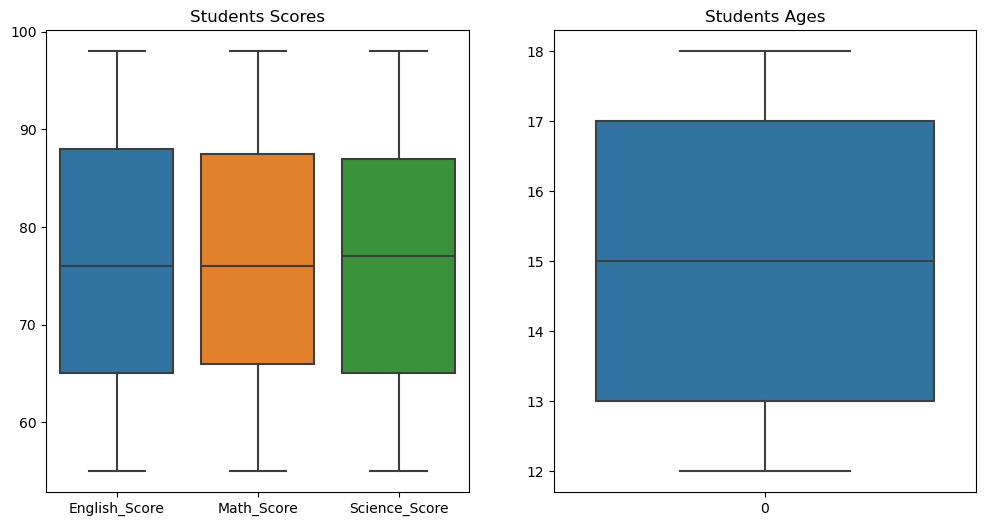

In [6]:
# plot boxplot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))

sns.boxplot(df.drop(['Age', 'Gender'], axis=1), ax=ax1)
sns.boxplot(df['Age'], ax=ax2)

ax1.set_title('Students Scores')
ax2.set_title('Students Ages')

plt.show()

Since there are no outliers, we can impute the missing values by mean

In [7]:
# impute missing values
missing_scores = ['English_Score', 'Math_Score']

for score in missing_scores:
    df[score] = df[score].fillna(df[score].mean())

In [8]:
# check for missing values
print(f'Missing values:\n{df.isnull().sum()}')

Missing values:
Gender           0
Age              0
English_Score    0
Math_Score       0
Science_Score    0
dtype: int64


From the output above, we can conclude that the missing data has been successfully imputed

### (d) One-Hot Encoding

As our dataset has categorical variables such as gender, we will need to perform one-hot encoding to convert them into dummy variables which are numerical values suitable for the unsupervised model

In [9]:
# view types of genders
df['Gender'].unique()

array(['Female', 'Male', 'Genderqueer', 'Non-binary', 'Agender',
       'Bigender', 'Genderfluid', 'Polygender'], dtype=object)

As there are quite alot of different genders, to maximise the models performance, we can reduce the types of genders to 3 types: male, female and others

In [10]:
# change gender types
df['Gender'] = df['Gender'].apply(lambda x: x if x in ['Male', 'Female'] else 'Others')

In [11]:
# check gender types
df['Gender'].unique()

array(['Female', 'Male', 'Others'], dtype=object)

In [12]:
# perform one-hot encoding
df = pd.get_dummies(df, dtype=int)
df

,Age,English_Score,Math_Score,Science_Score,Gender_Female,Gender_Male,Gender_Others
0,18,64.0,56.0,60,1,0,0
1,12,89.0,71.0,97,1,0,0
2,18,69.0,69.0,80,1,0,0
3,17,60.0,72.0,97,1,0,0
4,13,71.0,76.0,76,0,1,0
...,...,...,...,...,...,...,...
995,14,64.0,55.0,77,1,0,0
996,14,66.0,60.0,56,0,0,1
997,16,82.0,81.0,74,0,1,0
998,14,76.0,62.0,62,0,1,0


### (e) Data scaling

As unsupervised models like K-Means clustering uses distance between data, scaling the data will make sure that all the data will be in a similar scale whereby one feature will not have a bigger impact than the others

As there are 2 main types of methods to scale data:
1. Standardisation (Z-score normalisation)

2. Normalisation (Min-Max Scaling)

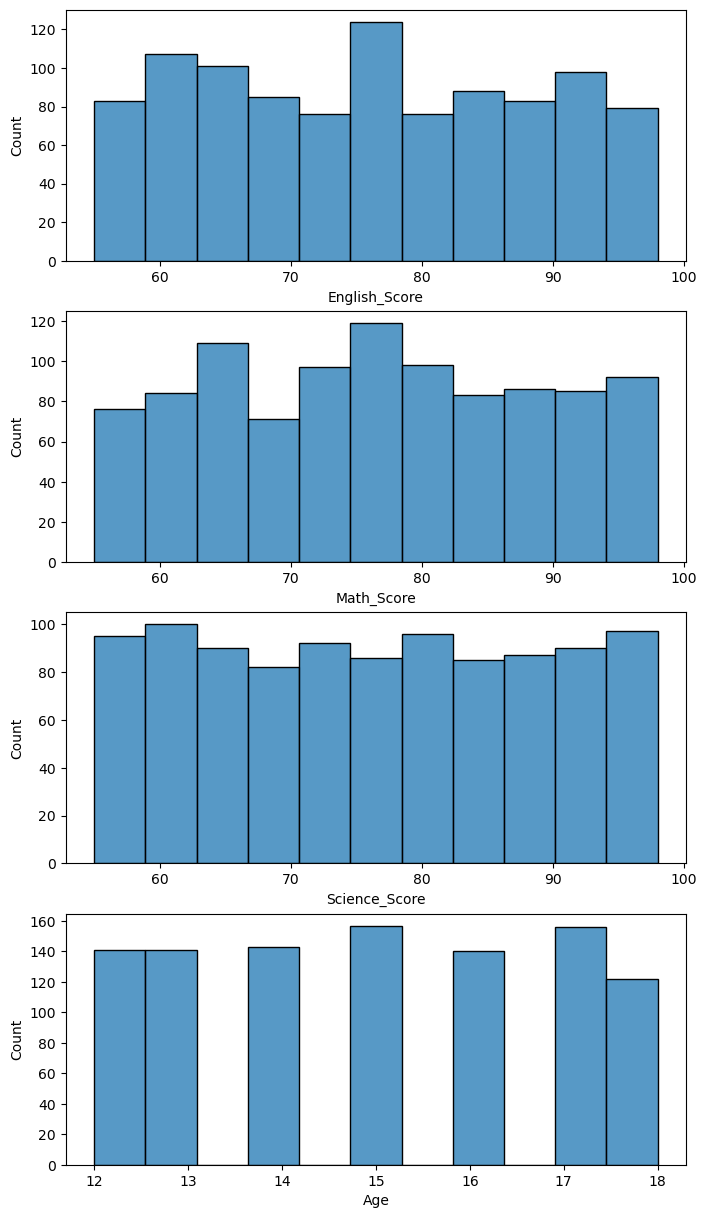

In [13]:
fig, ax = plt.subplots(4, 1, figsize=(8,15))

for i, score in enumerate(['English_Score', 'Math_Score', 'Science_Score', 'Age']):
    sns.histplot(df[score], ax=ax[i])

plt.show()

As the scores are not Gaussian (normally distributed), we will use standardisation as our method of scaling

In [14]:
scaler = StandardScaler()
scaled_df = df.copy()
scaled_df[['English_Score', 'Math_Score', 'Science_Score', 'Age']] = scaler.fit_transform(df[['English_Score', 'Math_Score', 'Science_Score', 'Age']])
scaled_df[['English_Score', 'Math_Score', 'Science_Score', 'Age']].describe()

,English_Score,Math_Score,Science_Score,Age
count,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03
mean,1.296740e-16,-1.394440e-15,-3.836931e-16,-3.659295e-16
std,1.000500e+00,1.000500e+00,1.000500e+00,1.000500e+00
min,-1.677219e+00,-1.757301e+00,-1.661714e+00,-1.516194e+00
25%,-8.819363e-01,-8.648913e-01,-8.841222e-01,-1.005691e+00
50%,-7.125600e-03,-1.152900e-15,4.898830e-02,1.531510e-02
75%,8.676851e-01,8.387994e-01,8.265803e-01,1.036321e+00
max,1.742496e+00,1.731209e+00,1.681932e+00,1.546825e+00


From the output above, we can see that the standard deviation of all the featuers are the same and the mean has changed

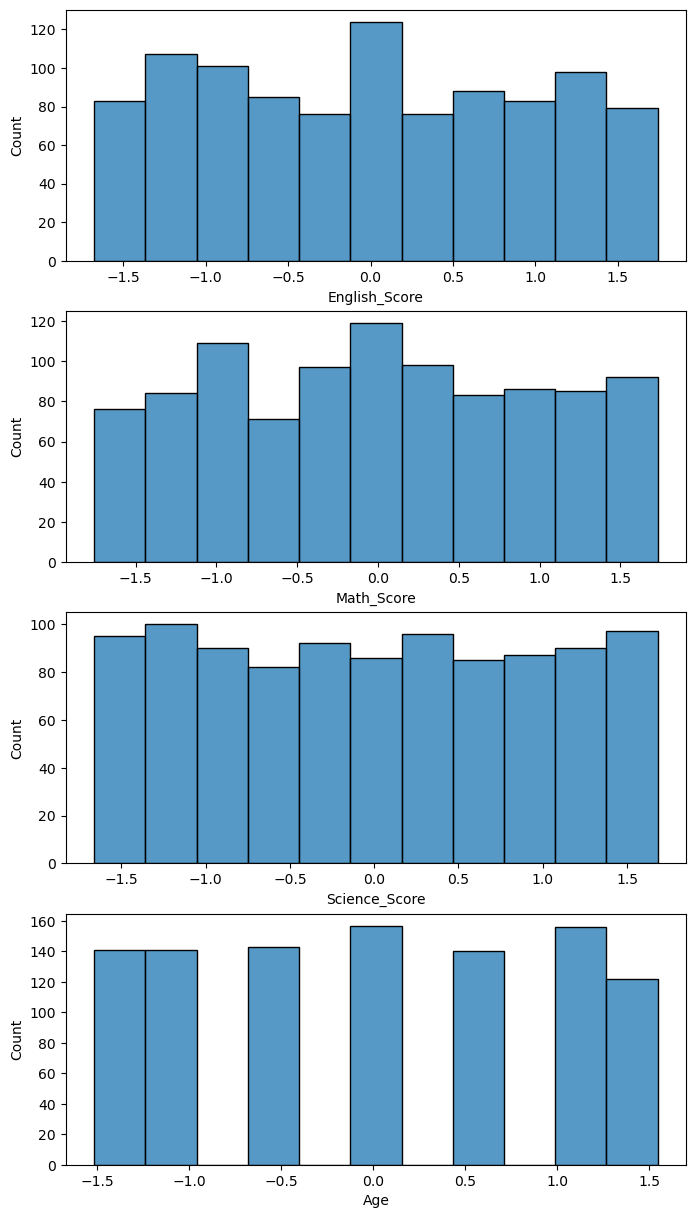

In [15]:
fig, ax = plt.subplots(4, 1, figsize=(8,15))

for i, score in enumerate(['English_Score', 'Math_Score', 'Science_Score', 'Age']):
    sns.histplot(scaled_df[score], ax=ax[i])

plt.show()

We can also see that the distribution of the data remained the same while the values have changed

### (f) PCA

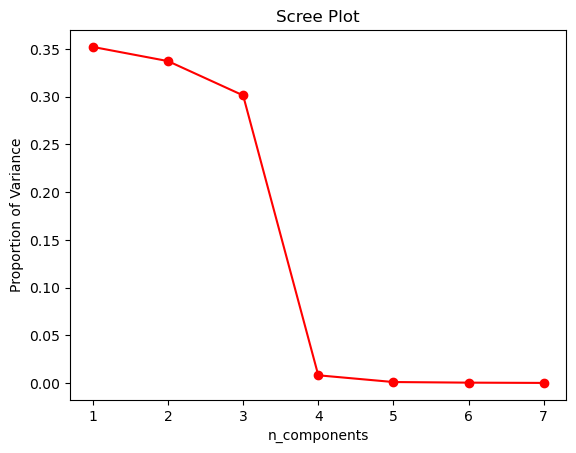

In [16]:
# make a copy of dataset
pca_df = scaled_df.copy()

# initialise a PCA with n_components being the total components in the dataset
pca = PCA(n_components=len(df.columns))
X_pca = pca.fit_transform(df)
prop_var = pca.explained_variance_ratio_
eigenvalues = pca.explained_variance_
PC_numbers = np.arange(pca.n_components_) + 1

# plot explanation variance for each pca
plt.plot(PC_numbers, 
         prop_var, 
         'ro-')
plt.title('Scree Plot')
plt.ylabel('Proportion of Variance')
plt.xlabel('n_components')
plt.show()

Although having 3 components would be ideal, the 3D PCA plot would be hard to interpret. Hence, for simplicity, we will only be using 2 components which will still account for almost 70% of the data

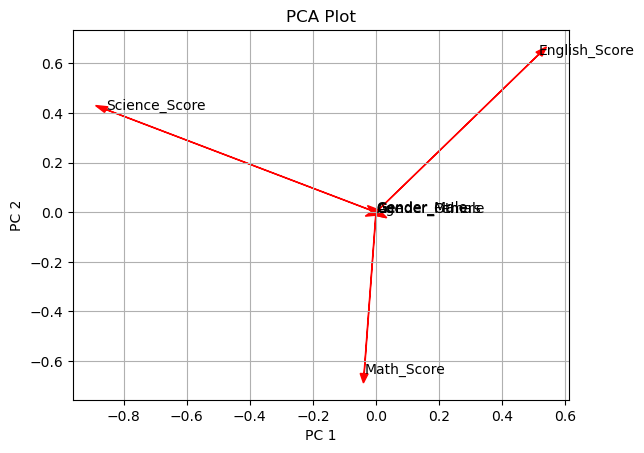

In [17]:
# make a copy of the dataset
pca_df = df.copy(deep=True)

# inititalise PCA with 2 components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(pca_df)

# coefficients of pca components
coeff = pca.components_

# pca names
pca_features = pca.n_features_in_
pc_names = [f'PC{i+1}' for i in range(pca_features)]

# match pca names to coeff
pc_list = dict(zip(pc_names, coeff))

# feature names
feature_names = df.columns

# Matrix of corr coefs between feature names and pcas
pc_df = pd.DataFrame.from_dict(pc_list)
pc_df['feature_names'] = feature_names
pc_df = pc_df.set_index('feature_names')
pc_df

# get coords of coeff
x = coeff[0]
y = coeff[1]

for i, varnames in enumerate(feature_names):
    plt.arrow(
        0, 0, # coordinates of arrow base
        x[i], # length of the arrow along x
        y[i], # length of the arrow along y
        color='r', 
        head_width=0.025
    )
    plt.text(x[i], y[i], varnames)

# customise plot
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.grid(True)
plt.title('PCA Plot')

plt.show()

This suggests that for:

PC1 -> English score is positively associated while Science score is negatively associated

PC2 -> Math score is negatively associated while Science and Math Score are positively associated

## 4. Model Selection

We can find the optimal k value by using 2 methods:
1. Elbow method
2. Silhouette method

In [18]:
silhouette_scores = []
inertia = []

for i, k in enumerate(np.arange(2, 12)):
    # initialise kmeans model
    model = KMeans(n_clusters=k, n_init=10, random_state=0)
    kmeans = model.fit(pca_df)
    labels = kmeans.labels_

    # calculate silhouette score
    score = silhouette_score(pca_df, labels)
    silhouette_scores.append(score)
    
    inertia.append(kmeans.inertia_)

#### (i) Elbow Method

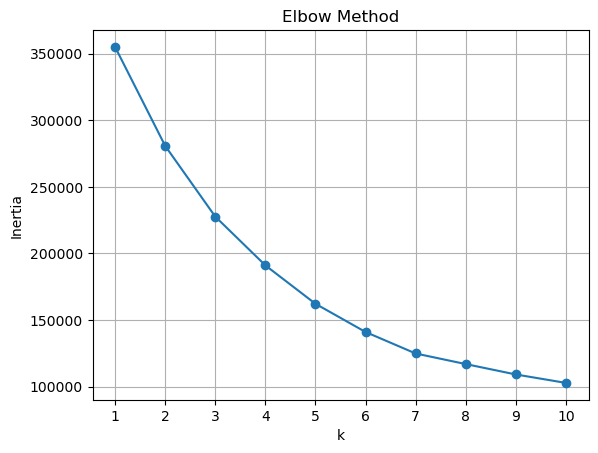

In [19]:
# plot out inertia results
plt.plot(range(1, 11), inertia, marker='o', linestyle='-')
plt.title('Elbow Method')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.xticks(range(1, 11))
plt.grid(True)
plt.show()

As there is no clear elbow in the plot, we will use the silhouette method

#### (ii) Silhouette method

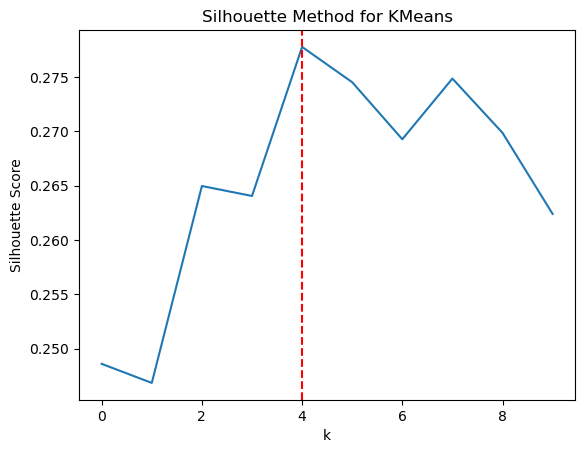

In [20]:
plt.plot(silhouette_scores)
plt.axvline(np.array(silhouette_scores).argmax(), color="red", linestyle="--")
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method for KMeans')
plt.show()

From the graph, we can conclude that the optimal k-value is 6

### (a) KMeans

In [21]:
# initialise kmeans model with 4 clusetrs
kmeans = KMeans(n_clusters=4,  n_init=10, random_state=0).fit(pca_df)

# add the predicted clusters
df['predicted_KMeans'] = kmeans.labels_

df['predicted_KMeans'].unique()

array([2, 0, 3, 1])

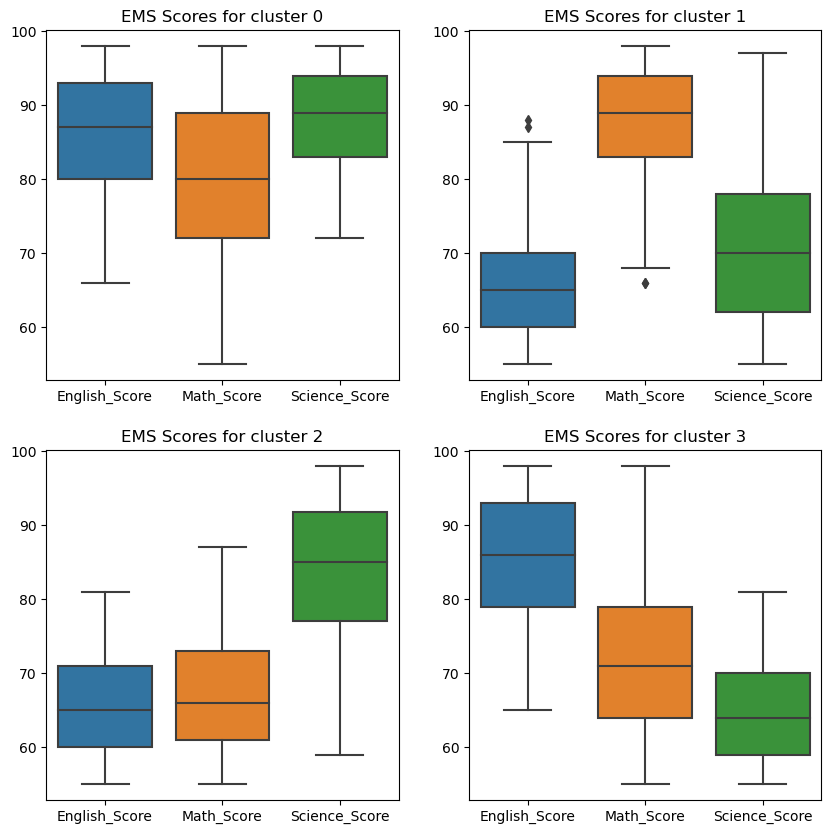

In [22]:
fig, ax = plt.subplots(2, 2, figsize=(10,10))

sns.boxplot(df[df['predicted_KMeans'] == 0][['English_Score', 'Math_Score', 'Science_Score']], ax=ax[0,0])
sns.boxplot(df[df['predicted_KMeans'] == 1][['English_Score', 'Math_Score', 'Science_Score']], ax=ax[0,1])
sns.boxplot(df[df['predicted_KMeans'] == 2][['English_Score', 'Math_Score', 'Science_Score']], ax=ax[1,0])
sns.boxplot(df[df['predicted_KMeans'] == 3][['English_Score', 'Math_Score', 'Science_Score']], ax=ax[1,1])

ax[0,0].set_title('EMS Scores for cluster 0')
ax[0,1].set_title('EMS Scores for cluster 1')
ax[1,0].set_title('EMS Scores for cluster 2')
ax[1,1].set_title('EMS Scores for cluster 3')

plt.show()

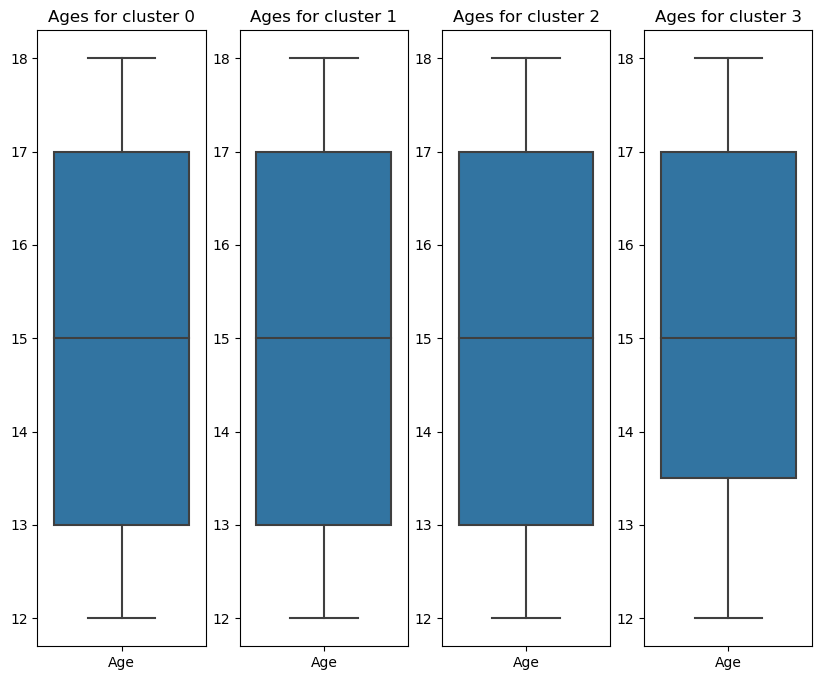

In [23]:
fig, ax = plt.subplots(1, 4, figsize=(10,8))

for i in range(len(df['predicted_KMeans'].unique())):
    sns.boxplot(df[df['predicted_KMeans'] == i][['Age']], ax=ax[i])
    ax[i].set_title(f'Ages for cluster {i}')

plt.show()

### (b) GMM

In [24]:
# initialise GMM model
GMM = GaussianMixture(n_components=4, random_state=0)

# Add the predicted clusters
df['predicted_GMM'] = GMM.fit_predict(pca_df)

df['predicted_GMM'].unique()

array([0, 1, 3, 2], dtype=int64)

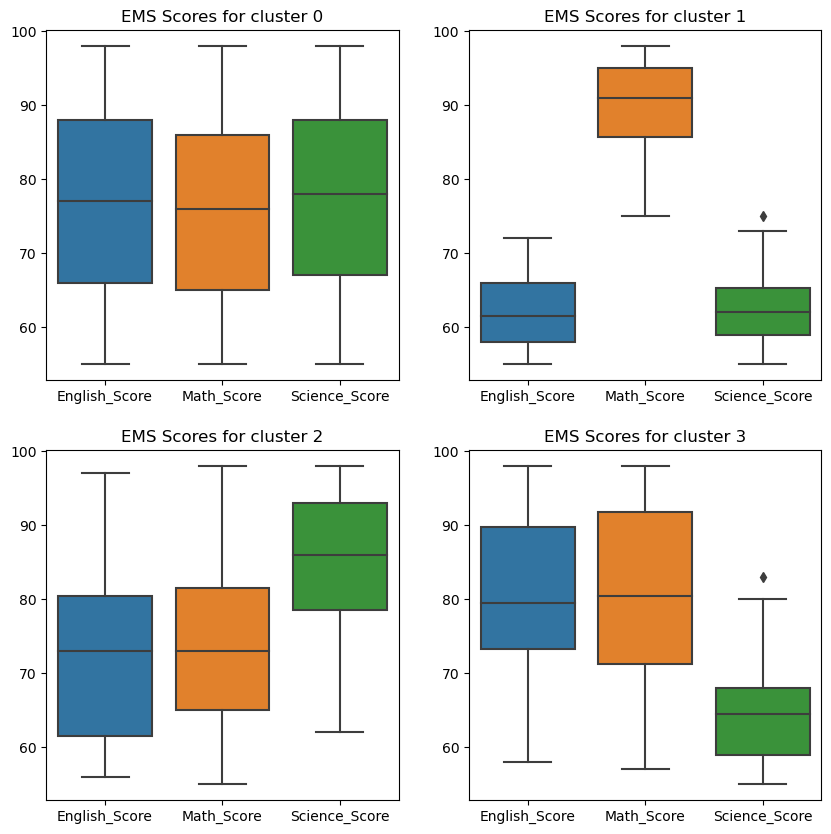

In [25]:
fig, ax = plt.subplots(2, 2, figsize=(10,10))

sns.boxplot(df[df['predicted_GMM'] == 0][['English_Score', 'Math_Score', 'Science_Score']], ax=ax[0,0])
sns.boxplot(df[df['predicted_GMM'] == 1][['English_Score', 'Math_Score', 'Science_Score']], ax=ax[0,1])
sns.boxplot(df[df['predicted_GMM'] == 2][['English_Score', 'Math_Score', 'Science_Score']], ax=ax[1,0])
sns.boxplot(df[df['predicted_GMM'] == 3][['English_Score', 'Math_Score', 'Science_Score']], ax=ax[1,1])

ax[0,0].set_title('EMS Scores for cluster 0')
ax[0,1].set_title('EMS Scores for cluster 1')
ax[1,0].set_title('EMS Scores for cluster 2')
ax[1,1].set_title('EMS Scores for cluster 3')

plt.show()

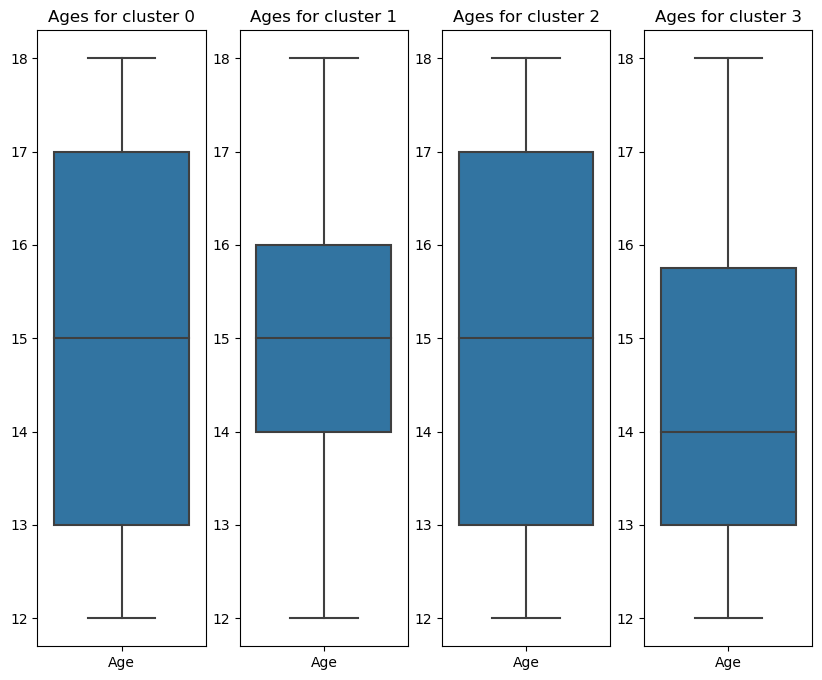

In [26]:
fig, ax = plt.subplots(1, 4, figsize=(10,8))

for i in range(len(df['predicted_GMM'].unique())):
    sns.boxplot(df[df['predicted_GMM'] == i][['Age']], ax=ax[i])
    ax[i].set_title(f'Ages for cluster {i}')

plt.show()